# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_041  I3L3E6;Q658N2              16.802
Sample_204  P54289;P54289-4;P54289-5   18.118
Sample_000  O15041;O15041-2            14.013
Sample_048  Q01469                     15.926
Sample_155  P54289-2;P54289-3          18.393
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups      
Sample_041  Q9UKZ4;Q9UKZ4-2        11.131
Sample_015  F5GX83;F5H2M3;Q9H3S3   13.882
Sample_167  P31151                 10.799
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.584
            A0A075B6Q5                 12.407
            A0A075B6R2                 14.847
            A0A075B6S5                 13.593
            A0A087WSY4                 12.576
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.302
            Q9UI40;Q9UI40-2            12.703
            Q9UIW2                     12.997
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.912
            Q9UP79                     13.572
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.034,15.050,16.842,19.863,15.831,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.960,19.067,...,15.528,15.576,14.258,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.996,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.361,17.705,17.039,15.039,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.578,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.738,15.345,17.084,18.708,14.249,19.433,12.148,11.111
Sample_207,15.739,16.877,15.469,16.898,14.149,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.379,13.086,13.946,12.301,12.528,12.673,13.810,12.763,13.000,12.338
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.165,19.067,16.127,...,11.991,12.913,14.294,14.303,12.616,13.124,12.410,13.359,11.672,12.614
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,10.844,13.189,11.206,13.089,11.973,12.942,12.020,13.419,13.570,13.630
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.769,12.975,12.364,12.323,13.083,12.159,12.487,13.444,13.086,13.039
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.917,11.957,13.374,12.616,13.528,12.950,13.939,12.371,13.507,11.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.70it/s]

100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.98it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.42it/s]

100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.12it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.21it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.92it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.90it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.63it/s]

100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.36it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.64it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.83it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.10it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.75it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.76it/s]

100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.00it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.36it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.44it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.28it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.36it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.45it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.64it/s]

 30%|███       | 3/10 [00:00<00:01,  5.62it/s]

 40%|████      | 4/10 [00:00<00:01,  4.63it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.70it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.81it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.81it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.91it/s]

100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.42it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.70it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.44it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.36it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.26it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.37it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.40it/s]

100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

100%|██████████| 11/11 [00:02<00:00,  4.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.85it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.98it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.82it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.96it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.15it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.09it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.22it/s]

100%|██████████| 12/12 [00:02<00:00,  4.25it/s]

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.95it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

 31%|███       | 4/13 [00:00<00:01,  4.98it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.08it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.98it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.12it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.30it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.23it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.25it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.27it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.25it/s]

100%|██████████| 13/13 [00:02<00:00,  4.11it/s]

100%|██████████| 13/13 [00:02<00:00,  4.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.68it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.30it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.98it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.22it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.49it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.50it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.53it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.39it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.38it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.50it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.42it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.34it/s]

100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.29it/s]

 20%|██        | 3/15 [00:00<00:02,  4.44it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.09it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.02it/s]

 40%|████      | 6/15 [00:01<00:02,  4.03it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.39it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.56it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.51it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.35it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.58it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.39it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.25it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.33it/s]

100%|██████████| 15/15 [00:03<00:00,  4.17it/s]

100%|██████████| 15/15 [00:03<00:00,  4.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.039 0.014          0.669 0.414       0.086   
2             0.004 0.003      0.056 0.029          0.696 0.131       0.528   
3             0.005 0.004      0.051 0.018          0.700 0.121       0.619   
4             0.004 0.003      0.043 0.014          0.709 0.110       0.624   
5             0.006 0.006      0.058 0.025          0.687 0.092       0.666   
6             0.005 0.004      0.055 0.023          0.802 0.081       0.805   
7             0.006 0.005      0.059 0.023          0.795 0.082       0.801   
8             0.005 0.005      0.054 0.022          0.793 0.089       0.787   
9             0.004 0.003      0.048 0.022          0.790 0.091       0.791   
10            0.003 0.000      0.037 0.018          0.792 0.089       0.788   
11            0.004 0.000      0.039 0.013          0.794 0.086       0.798   
12            0.004 0.001      0.038 0.011          0.813 0.088       0.804   
13            0.004 0.003      0.039 0.012          0.803 0.090       0.800   
14            0.004 0.002      0.041 0.014          0.798 0.093       0.795   
15            0.003 0.001      0.032 0.009          0.794 0.089       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.147 0.116                  0.536 0.035        0.844   
2          0.109   0.592 0.090                  0.675 0.065        0.721   
3          0.128   0.646 0.090                  0.705 0.071        0.780   
4          0.103   0.657 0.079                  0.714 0.063        0.802   
5          0.112   0.671 0.079                  0.720 0.065        0.798   
6          0.111   0.798 0.071                  0.828 0.058        0.891   
7          0.109   0.793 0.070                  0.824 0.058        0.888   
8          0.099   0.785 0.067                  0.816 0.056        0.887   
9          0.107   0.785 0.072                  0.816 0.060        0.887   
10         0.108   0.785 0.074                  0.816 0.062        0.889   
11         0.115   0.790 0.073                  0.821 0.061        0.896   
12         0.107   0.803 0.070                  0.832 0.058        0.905   
13         0.109   0.795 0.072                  0.826 0.059        0.904   
14         0.101   0.791 0.070                  0.821 0.058        0.903   
15         0.103   0.788 0.069                  0.819 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.820 0.089        210.000 0.000  
2          0.080                  0.686 0.098        210.000 0.000  
3          0.078                  0.714 0.097        210.000 0.000  
4          0.072                  0.762 0.094        210.000 0.000  
5          0.066                  0.755 0.092        210.000 0.000  
6          0.050                  0.860 0.063        210.000 0.000  
7          0.051                  0.858 0.064        210.000 0.000  
8          0.052                  0.855 0.067        210.000 0.000  
9          0.054                  0.858 0.065        210.000 0.000  
10         0.054                  0.864 0.064        210.000 0.000  
11         0.053                  0.879 0.057        210.000 0.000  
12         0.052                  0.893 0.052        210.000 0.000  
13         0.052                  0.892 0.053        210.000 0.000  
14         0.052                  0.891 0.052        210.000 0.000  
15         0.051                  0.891 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 515.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.12it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.01it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.72it/s]

100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.22it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.01it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.40it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 13.46it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  8.05it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.89it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.94it/s]

100%|██████████| 7/7 [00:01<00:00,  5.12it/s]

100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.49it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.29it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.66it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.30it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.10it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.02it/s]

100%|██████████| 8/8 [00:01<00:00,  3.69it/s]

100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.36it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.62it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.77it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.63it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.41it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.35it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.16it/s]

100%|██████████| 9/9 [00:02<00:00,  4.04it/s]

100%|██████████| 9/9 [00:02<00:00,  4.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.90it/s]

 30%|███       | 3/10 [00:00<00:01,  5.20it/s]

 40%|████      | 4/10 [00:00<00:01,  4.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.56it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.61it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.03it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.21it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.53it/s]

100%|██████████| 10/10 [00:01<00:00,  5.77it/s]

100%|██████████| 10/10 [00:01<00:00,  5.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.08it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.48it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.54it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.72it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.50it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.20it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.06it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.89it/s]

100%|██████████| 11/11 [00:02<00:00,  3.89it/s]

100%|██████████| 11/11 [00:02<00:00,  4.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.26it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.80it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.27it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.08it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.47it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  7.06it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.92it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  7.01it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.77it/s]

100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

100%|██████████| 12/12 [00:01<00:00,  7.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.85it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.16it/s]

 31%|███       | 4/13 [00:00<00:01,  5.75it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.48it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.12it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.87it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.89it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.83it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.86it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.76it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.72it/s]

100%|██████████| 13/13 [00:02<00:00,  4.65it/s]

100%|██████████| 13/13 [00:02<00:00,  5.05it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.85it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.30it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.41it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.92it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.82it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.76it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.72it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.51it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.82it/s]

100%|██████████| 14/14 [00:01<00:00,  7.58it/s]

100%|██████████| 14/14 [00:01<00:00,  8.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.37it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.07it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.44it/s]

 40%|████      | 6/15 [00:00<00:01,  7.17it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.91it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.65it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.78it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.81it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.11it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.36it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.64it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.85it/s]

100%|██████████| 15/15 [00:01<00:00,  8.06it/s]

100%|██████████| 15/15 [00:01<00:00,  7.52it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.040 0.009          0.000 0.000       0.000   
2             0.003 0.002      0.039 0.008          0.704 0.121       0.534   
3             0.006 0.006      0.073 0.019          0.755 0.110       0.617   
4             0.006 0.006      0.060 0.024          0.774 0.100       0.605   
5             0.003 0.000      0.034 0.003          0.748 0.078       0.649   
6             0.003 0.002      0.027 0.009          0.771 0.088       0.790   
7             0.003 0.000      0.033 0.002          0.772 0.087       0.800   
8             0.002 0.001      0.024 0.006          0.792 0.086       0.799   
9             0.003 0.001      0.034 0.004          0.785 0.090       0.798   
10            0.002 0.000      0.020 0.002          0.789 0.084       0.804   
11            0.003 0.000      0.032 0.004          0.791 0.082       0.796   
12            0.002 0.000      0.022 0.004          0.801 0.082       0.799   
13            0.002 0.001      0.023 0.006          0.851 0.082       0.800   
14            0.002 0.000      0.020 0.001          0.848 0.082       0.809   
15            0.002 0.000      0.019 0.000          0.841 0.085       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.860   
2          0.134   0.599 0.114                  0.683 0.080        0.738   
3          0.129   0.668 0.098                  0.731 0.066        0.782   
4          0.120   0.672 0.095                  0.736 0.062        0.800   
5          0.113   0.688 0.078                  0.743 0.054        0.803   
6          0.111   0.774 0.072                  0.807 0.061        0.890   
7          0.112   0.779 0.067                  0.811 0.057        0.892   
8          0.120   0.789 0.078                  0.821 0.064        0.895   
9          0.113   0.786 0.077                  0.817 0.064        0.893   
10         0.111   0.791 0.070                  0.821 0.059        0.893   
11         0.108   0.789 0.074                  0.820 0.063        0.905   
12         0.112   0.795 0.077                  0.826 0.065        0.906   
13         0.112   0.819 0.076                  0.848 0.062        0.919   
14         0.109   0.823 0.073                  0.850 0.060        0.919   
15         0.112   0.818 0.078                  0.846 0.064        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.829 0.086        210.000 0.000  
2          0.078                  0.674 0.098        210.000 0.000  
3          0.073                  0.749 0.090        210.000 0.000  
4          0.068                  0.774 0.083        210.000 0.000  
5          0.067                  0.778 0.082        210.000 0.000  
6          0.052                  0.861 0.062        210.000 0.000  
7          0.050                  0.860 0.064        210.000 0.000  
8          0.053                  0.867 0.064        210.000 0.000  
9          0.052                  0.864 0.063        210.000 0.000  
10         0.050                  0.861 0.062        210.000 0.000  
11         0.048                  0.886 0.053        210.000 0.000  
12         0.049                  0.889 0.053        210.000 0.000  
13         0.044                  0.900 0.053        210.000 0.000  
14         0.044                  0.899 0.053        210.000 0.000  
15         0.045                  0.898 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1204.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.90it/s]

100%|██████████| 5/5 [00:00<00:00, 43.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.83it/s]

100%|██████████| 6/6 [00:00<00:00, 41.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.77it/s]

100%|██████████| 7/7 [00:00<00:00, 40.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.01it/s]

100%|██████████| 8/8 [00:00<00:00, 40.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.11it/s]

100%|██████████| 9/9 [00:00<00:00, 39.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.04it/s]

100%|██████████| 10/10 [00:00<00:00, 38.49it/s]

100%|██████████| 10/10 [00:00<00:00, 39.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.00it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.44it/s]

100%|██████████| 11/11 [00:00<00:00, 38.68it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.01it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.67it/s]

100%|██████████| 12/12 [00:00<00:00, 38.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.99it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.45it/s]

100%|██████████| 13/13 [00:00<00:00, 38.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.08it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.70it/s]

100%|██████████| 14/14 [00:00<00:00, 37.37it/s]

100%|██████████| 14/14 [00:00<00:00, 38.17it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.90it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.40it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.12it/s]

100%|██████████| 15/15 [00:00<00:00, 37.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.643 0.094       0.449   
3             0.002 0.000      0.019 0.000          0.665 0.085       0.550   
4             0.002 0.000      0.019 0.000          0.700 0.082       0.599   
5             0.002 0.000      0.019 0.000          0.693 0.091       0.596   
6             0.002 0.000      0.019 0.000          0.699 0.088       0.601   
7             0.002 0.000      0.019 0.000          0.694 0.102       0.636   
8             0.002 0.000      0.019 0.000          0.703 0.093       0.649   
9             0.002 0.000      0.019 0.000          0.709 0.102       0.640   
10            0.002 0.000      0.019 0.000          0.692 0.095       0.633   
11            0.002 0.000      0.019 0.000          0.688 0.100       0.626   
12            0.002 0.000      0.019 0.000          0.687 0.102       0.620   
13            0.002 0.000      0.019 0.000          0.681 0.100       0.616   
14            0.002 0.000      0.019 0.000          0.687 0.103       0.624   
15            0.002 0.000      0.019 0.000          0.688 0.096       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.748   
2          0.080   0.524 0.074                  0.632 0.050        0.724   
3          0.099   0.598 0.079                  0.674 0.057        0.768   
4          0.114   0.640 0.084                  0.705 0.061        0.801   
5          0.114   0.635 0.087                  0.700 0.065        0.799   
6          0.112   0.640 0.084                  0.705 0.062        0.795   
7          0.117   0.658 0.093                  0.714 0.072        0.809   
8          0.111   0.669 0.083                  0.723 0.064        0.810   
9          0.109   0.667 0.086                  0.722 0.068        0.807   
10         0.113   0.655 0.085                  0.712 0.065        0.809   
11         0.112   0.650 0.088                  0.707 0.069        0.810   
12         0.110   0.646 0.086                  0.704 0.067        0.808   
13         0.115   0.641 0.089                  0.701 0.069        0.805   
14         0.111   0.648 0.089                  0.706 0.069        0.801   
15         0.106   0.652 0.083                  0.709 0.065        0.800   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.689 0.078        210.000 0.000  
2          0.068                  0.683 0.072        210.000 0.000  
3          0.060                  0.723 0.068        210.000 0.000  
4          0.057                  0.757 0.073        210.000 0.000  
5          0.059                  0.757 0.074        210.000 0.000  
6          0.059                  0.753 0.073        210.000 0.000  
7          0.062                  0.767 0.076        210.000 0.000  
8          0.063                  0.767 0.086        210.000 0.000  
9          0.064                  0.766 0.082        210.000 0.000  
10         0.067                  0.773 0.079        210.000 0.000  
11         0.064                  0.772 0.077        210.000 0.000  
12         0.064                  0.768 0.079        210.000 0.000  
13         0.064                  0.765 0.079        210.000 0.000  
14         0.064                  0.760 0.079        210.000 0.000  
15         0.064                  0.758 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,4,15
score_time,7,3,13
test_precision,12,13,9
test_recall,6,14,8
test_f1,12,14,8
test_balanced_accuracy,12,14,8
test_roc_auc,12,13,11
test_average_precision,12,13,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.30it/s]

 31%|███       | 4/13 [00:00<00:00, 10.82it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.80it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.35it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.01it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.90it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.84it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.75it/s]

100%|██████████| 13/13 [00:01<00:00,  8.68it/s]

100%|██████████| 13/13 [00:01<00:00,  9.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.94it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.44it/s]

100%|██████████| 11/11 [00:00<00:00, 38.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 18.09it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.85it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.31it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.11it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.99it/s]

100%|██████████| 12/12 [00:01<00:00,  9.96it/s]

100%|██████████| 12/12 [00:01<00:00, 10.32it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


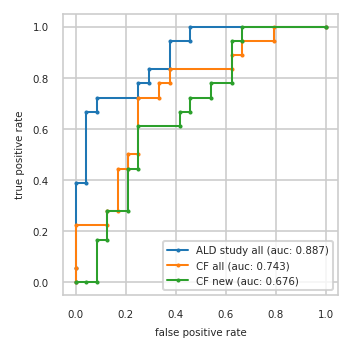

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.222  0.083 0.000
3          0.042 0.389  0.125 0.222  0.083 0.167
4          0.042 0.667  0.125 0.278  0.125 0.167
5          0.083 0.667  0.167 0.278  0.125 0.278
6          0.083 0.722  0.167 0.444  0.208 0.278
7          0.250 0.722  0.208 0.444  0.208 0.444
8          0.250 0.778  0.208 0.500  0.250 0.444
9          0.292 0.778  0.250 0.500  0.250 0.611
10         0.292 0.833  0.250 0.722  0.417 0.611
11         0.375 0.833  0.333 0.722  0.417 0.667
12         0.375 0.944  0.333 0.778  0.458 0.667
13         0.458 0.944  0.375 0.778  0.458 0.722
14         0.458 1.000  0.375 0.833  0.542 0.722
15         1.000 1.000  0.625 0.833  0.542 0.778
16           NaN   NaN  0.625 0.889  0.625 0.778
17           NaN   NaN  0.667 0.889  0.625 0.944
18           NaN   NaN  0.667 0.944  0.667 0.944
19           NaN   NaN  0.792 0.944  0.667 1.000
20           NaN   NaN  0.792 1.000  1.000 1.000
21           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,F5GWQ8;J3QKW8;Q15846,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,P09486,P26572,Q96GD0
3,K7ERG9;P00746,P04075,P31321
4,P14174,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
5,P10636-2;P10636-6,P25189;P25189-2,J3KSJ8;Q9UD71;Q9UD71-2
6,P61981,P61981,P51688
7,Q6EMK4,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,Q14894,E9PK25;G3V1A4;P23528


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


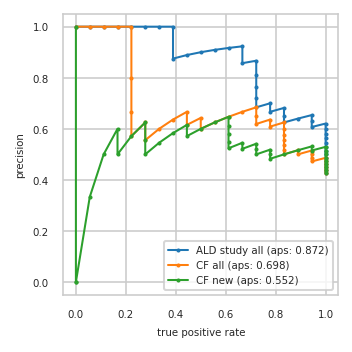

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.472 0.944     0.500 1.000
7          0.514 1.000     0.486 0.944     0.514 1.000
8          0.529 1.000     0.500 0.944     0.529 1.000
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.562 1.000     0.500 0.889     0.531 0.944
11         0.581 1.000     0.516 0.889     0.516 0.889
12         0.600 1.000     0.500 0.833     0.500 0.833
13         0.621 1.000     0.517 0.833     0.483 0.778
14         0.607 0.944     0.536 0.833     0.500 0.778
15         0.630 0.944     0.556 0.833     0.519 0.778
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.619 0.722     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.765 0.722     0.647 0.611     0.647 0.611
26         0.812 0.722     0.625 0.556     0.625 0.556
27         0.867 0.722     0.600 0.500     0.600 0.500
28         0.857 0.667     0.643 0.500     0.571 0.444
29         0.923 0.667     0.615 0.444     0.615 0.444
30         0.917 0.611     0.667 0.444     0.583 0.389
31         0.909 0.556     0.636 0.389     0.545 0.333
32         0.900 0.500     0.600 0.333     0.500 0.278
33         0.889 0.444     0.556 0.278     0.556 0.278
34         0.875 0.389     0.625 0.278     0.625 0.278
35         1.000 0.389     0.571 0.222     0.571 0.222
36         1.000 0.333     0.667 0.222     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


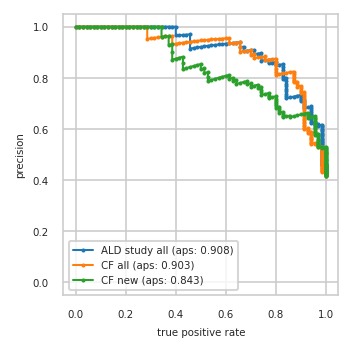

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


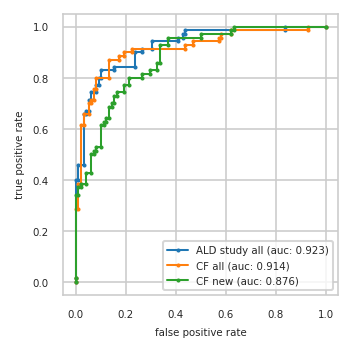

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}